In [9]:
import pandas as pd
from __future__ import annotations
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import matplotlib as mpl
import matplotlib.transforms as mtrans
import seaborn as sns
sns.set_theme('notebook', 'white', 'husl')

In [10]:
df = pd.read_parquet('./BTC_data.parquet')
df_plot = df[['EMA_50', 'vol', 'ADX', 'close']].iloc[-120:,:]
df_plot = df_plot.rename({'close' : 'BTC price', 'vol' : 'volatility', 'EMA_50' : 'EMA', 'RSI_14': 'RSI'},axis = 1)

In [11]:
import warnings
warnings.filterwarnings("ignore")
def build_figure(                         # ───────── configurable ──────────
    df: pd.DataFrame,
    L: int = 24,                         # patch/window length
    S: int = 24,                         # stride
    prompt_words: list[str] | None = None,
    n_name_tokens: int = 2,              # how many column names to inject
    figsize: tuple = (18, 8),
    save_prefix: str = "df_based_embedding_diagram_long_prompt",
) -> None:
    # ───────────── checks & constants ──────────────────────────────────────
    if df.empty:
        raise ValueError("DataFrame `df` is empty.")
    if L <= 0 or S <= 0:
        raise ValueError("L and S must be positive.")
    T = len(df)                          # sequence length
    if L > T:
        raise ValueError("patch length L cannot exceed sequence length T.")
    n_series = len(df.columns)
    K = math.floor((T - L) / S) + 1  # number of patches per series

    # prompt construction ---------------------------------------------------
    if prompt_words is None:
        prompt_words = [ "EMA", "...", "ADX", '...']
    prompt_tokens = prompt_words + ["[EOS]"]      # append EOS
    P = len(prompt_tokens)

    # style -----------------------------------------------------------------
    mpl.rcParams.update({
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "svg.fonttype": "none",
        "font.size": 12,
        "axes.linewidth": 0.8,
    })

    # colour palettes -------------------------------------------------------
    ts_colors   = ['C0', 'C1','C2','C3']
    patch_color = "#bababa"

    prompt_col = "#fff2b3"
    seq_col    = "#bababa"

    # layout ---------------------------------------------------------------
    x_left  = 0.05
    w_ts    = 0.46
    tok_gap = 0.10
    h_row   = 0.11
    gap_pan = 0.10

    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    canvas = fig.add_axes([0, 0, 1, 1]); canvas.set_axis_off()

    # =================== PANEL (a) : Patch embedder =======================
    top_a = 1.0 - 0.05
    fig.text(0.02, top_a, "(a) Patch embedder – independent streams",
             weight="bold", fontsize=18, va="top")

    ax_ts_list_a, tok_row_list_a = [], []

    for row, col_name in enumerate(df.columns):
        y_base  = top_a - 0.12 - row * h_row
        series  = df[col_name].values
        ts_col  = ts_colors[row % len(ts_colors)]

        # label left of plot
        fig.text(x_left - 0.03, y_base + h_row * 0.275,
                 col_name, ha="right", va="center", fontsize=14,
                 color=ts_col)

        # time-series axis --------------------------------------------------
        ax_ts = fig.add_axes([x_left, y_base, w_ts, h_row * 0.55])
        ax_ts.set_xlim(0, T - 1); ax_ts.set_xticks([]); ax_ts.set_yticks([])
        ax_ts.spines[['right', 'top']].set_visible(False)

        # uniform-colour patches + text “Patch i”
        for p in range(K):
            start = p * S
            ax_ts.axvspan(start, start + L - 1,
                          facecolor=patch_color, alpha=0.30, zorder=0)
            x_mid = start + L / 2
            # if p == 0 and row == 0 :
            #     ax_ts.text(x_mid, 1.1, f"Patch",
            #             transform=mtrans.blended_transform_factory(
            #                 ax_ts.transData, ax_ts.transAxes),
            #             ha='center', va='center', fontsize=10, color="black")

        # time-series curve
        ax_ts.plot(range(T), series, color=ts_col, lw=1.1, zorder=1)

        # token strip -------------------------------------------------------
        tok_row = fig.add_axes([
            x_left + w_ts + tok_gap, y_base,
            1 - (x_left + w_ts + tok_gap) - 0.05, h_row * 0.55])
        tok_row.set_axis_off()

        tok_w, y_c = 1 / (P + K - 0.7), 0.5

        # prompt tokens
        for p_idx, word in enumerate(prompt_tokens):
            x_tok = tok_w * p_idx + 0.03
            tok_row.add_patch(Rectangle((x_tok, y_c - 0.22),
                                        tok_w * 0.9, 0.6,
                                        fc=prompt_col, ec="black", lw=0.9))
            tok_row.text(x_tok + tok_w * 0.45, y_c, word,
                         ha="center", va="center", fontsize=12)

        # patch tokens (same colour for all)
        for p in range(K-1):
            x_tok = tok_w * (P + p) + 0.03
            tok_row.add_patch(Rectangle((x_tok, y_c - 0.22),
                                        tok_w * 0.9, 0.6,
                                        fc=ts_col, ec="black", lw=0.9))
            tok_row.text(x_tok + tok_w * 0.45, y_c, f"Patch{p+1}",
                         ha="center", va="center", fontsize=12)

        # encoder boundary
        # tok_row.add_patch(Rectangle((0, 0), 1, 1,
        #                             fill=False, linestyle="--", lw=0.9, ec = 'black'))
        if col_name == "BTC price":
            tok_row.text(0.5, -0.30, "Univariate Encoders",
                            ha="center", va="top", fontsize=14,
                            transform=tok_row.transAxes)

        ax_ts_list_a.append(ax_ts); tok_row_list_a.append(tok_row)

    # ── arrows & labels for panel (a) ─────────────────────────────────
    for ax_ts, tok_row in zip(ax_ts_list_a, tok_row_list_a):
        pos_ts, pos_tok = ax_ts.get_position(), tok_row.get_position()
        xy_start = (pos_ts.x1, pos_ts.y0 + pos_ts.height * 0.5)
        xy_end   = (pos_tok.x0, pos_tok.y0 + pos_tok.height * 0.5)

        fig.add_artist(FancyArrowPatch(
            xy_start, xy_end, arrowstyle='-|>', mutation_scale=8,
            lw=1, color='black', transform=fig.transFigure, clip_on=False))

        x_mid = (xy_start[0] + xy_end[0]) / 2
        y_mid = (xy_start[1] + xy_end[1]) / 2 + 0.01
        fig.text(x_mid, y_mid, "linear embedding",
                 ha='center', va='bottom', fontsize=12)
        fig.text(x_mid, y_mid - 0.04, "Patch Reprogram",
                 ha='center', va='bottom', fontsize=12)

    # =================== PANEL (b) : Inverted embedder =====================
    top_b = top_a - n_series * h_row - gap_pan
    fig.text(0.02, top_b, "(b) Inverted embedder – shared stream",
             weight="bold", fontsize=18, va="top")

    ax_ts_list_b = []
    for row, col_name in enumerate(df.columns):
        y_base = top_b - 0.12 - row * h_row
        series = df[col_name].values
        ts_col = ts_colors[row % len(ts_colors)]

        fig.text(x_left - 0.03, y_base + h_row * 0.275,
                 col_name, ha="right", va="center", fontsize=14, color=ts_col)

        ax_ts = fig.add_axes([x_left, y_base, w_ts, h_row * 0.55])
        ax_ts.set_xlim(0, T - 1); ax_ts.set_xticks([]); ax_ts.set_yticks([])
        ax_ts.spines[['right', 'top']].set_visible(False)

        ax_ts.axvspan(0, T - 1, facecolor=patch_color, alpha=0.35, zorder=0)
        ax_ts.plot(range(T), series, color=ts_colors[row], lw=1.1, zorder=1)

        ax_ts_list_b.append(ax_ts)

    # shared token strip ----------------------------------------------------
    y_strip = top_b - 0.04 - n_series * h_row + 0.19
    tok_strip = fig.add_axes([
        x_left + w_ts + tok_gap, y_strip,
        1 - (x_left + w_ts + tok_gap) - 0.05, 0.08])
    tok_strip.set_axis_off()

    tok_w, y_c = 1 / (P + n_series + 0.5), 0.5

    for p_idx, word in enumerate(prompt_tokens):
        x_tok = tok_w * p_idx + 0.03
        tok_strip.add_patch(Rectangle((x_tok, y_c - 0.22),
                                      tok_w * 0.9, 0.5,
                                      fc=prompt_col, ec="black", lw=0.9))
        tok_strip.text(x_tok + tok_w * 0.45, y_c, word,
                       ha="center", va="center", fontsize=12)

    for s_idx in range(n_series):
        x_tok = tok_w * (P + s_idx) + 0.03
        tok_strip.add_patch(Rectangle((x_tok, y_c - 0.22),
                                      tok_w * 0.9, 0.5,
                                      fc=ts_colors[s_idx], ec="black", lw=0.9))
        tok_strip.text(x_tok + tok_w * 0.45, y_c, f"Seq {s_idx+1}",
                       ha="center", va="center", fontsize=12)

    tok_strip.add_patch(Rectangle((0, 0), 1, 1,
                                  fill=False, linestyle="--", lw=0.9))
    tok_strip.text(0.5, -0.30, "Shared Encoder",
                   ha="center", va="top", fontsize=14,
                   transform=tok_strip.transAxes)

    # arrow & label for panel (b) ------------------------------------------
    ax_mid   = ax_ts_list_b[len(ax_ts_list_b)//2]
    pos_mid  = ax_mid.get_position()
    pos_tok  = tok_strip.get_position()

    xy_start = (pos_mid.x1, pos_mid.y0 + pos_mid.height * 1.5)
    xy_end   = (pos_tok.x0, pos_tok.y0 + pos_tok.height * 0.5)

    fig.add_artist(FancyArrowPatch(
        xy_start, xy_end, arrowstyle='-|>', mutation_scale=8,
        lw=1, color='black', transform=fig.transFigure, clip_on=False))

    x_mid_b = (xy_start[0] + xy_end[0]) / 2
    y_mid_b = (xy_start[1] + xy_end[1]) / 2 + 0.01
    fig.text(x_mid_b, y_mid_b, "linear embedding",
             ha='center', va='bottom', fontsize=12)
    fig.text(x_mid_b, y_mid_b - 0.04, "Sequence Reprogram",
             ha='center', va='bottom', fontsize=12)
        # ----------------------------------------------------------------------
    # legend  ➜  the pale-yellow squares correspond to prompt-tokens
    # ----------------------------------------------------------------------
    import matplotlib.patches as mpatches

    prompt_handle = mpatches.Patch(facecolor=prompt_col,
                                   edgecolor="black",
                                   label="Prompt Prefix tokens")

    # place the legend in the top-right corner of the whole figure
    fig.legend(handles=[prompt_handle],
               loc="lower right",
            #    bbox_to_anchor=(0.98, 0.98),      # x, y in figure coords
               fontsize=14,
               frameon=False,
            handlelength=2.5,     # <- width  (default ≈ 2.)
           handleheight=1.2)
    # save & show -----------------------------------------------------------
    plt.tight_layout()
    fig.savefig(f"./embedding_diagram.png", dpi=300, transparent= True, bbox_inches="tight")
    print('----- Figure Saved -----')
    plt.show()


----- Figure Saved -----


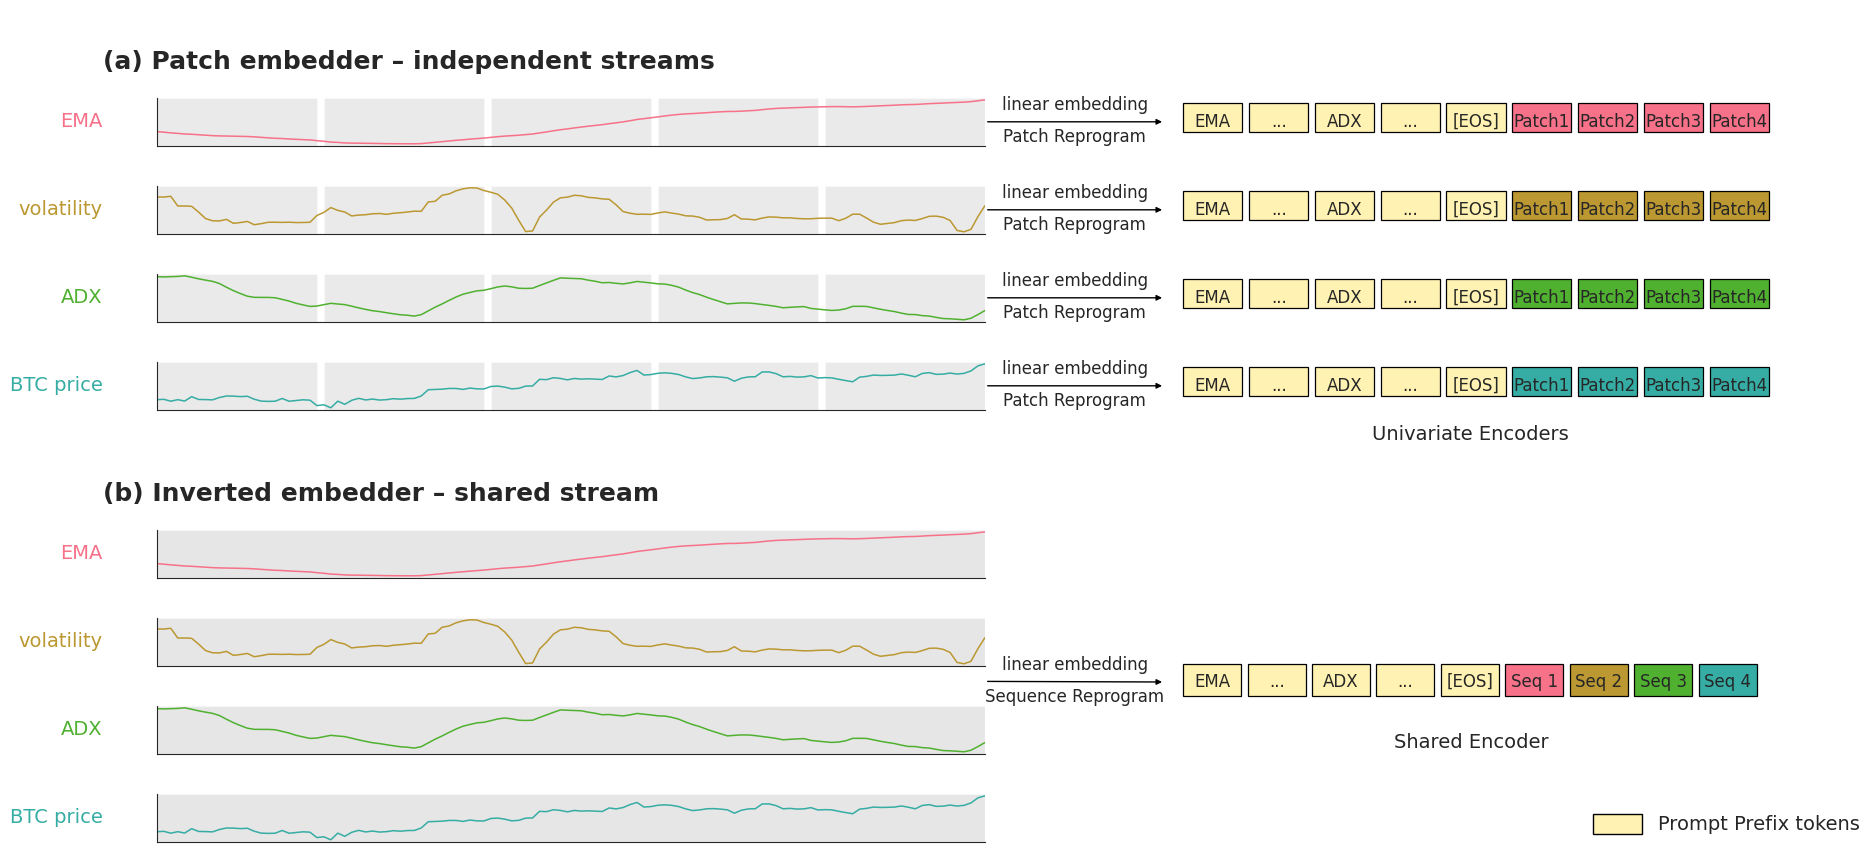

In [12]:
build_figure(df_plot)